PROYECTO MACHINE LEARNING
==

Este proyecto de Machine Learning está diseñado para ayudar a profesionales que buscan empleo en el sector tecnológico, específicamente en roles relacionados con la inteligencia artificial. Su objetivo principal es proporcionar una estimación informada del rango salarial que pueden solicitar durante una entrevista de trabajo, en función de diversos factores relevantes del mercado laboral. De esta manera, los candidatos podrán afrontar con mayor seguridad y conocimiento la parte de la entrevista relacionada con la negociación salarial.

Para abordar este problema, se ha planteado un enfoque supervisado de **regresión**, con el fin de predecir el salario esperado en función de diversas variables, evaluando su rendimiento mediante la métrica **MAE** (Mean Absolute Error).

El conjunto de datos se ha extraido de la plataforma Kaggle, en la URL adjunta pueden acceder a su contenido, https://www.kaggle.com/datasets/bismasajjad/global-ai-job-market-and-salary-trends-2025/data, de la cual se han descargado los datos en fichero CSV


##### El dataset cuenta con las siguientes columnas


- job_id : identificador uniqco para cada puesto de trabajo
- job_title : Título estandarizado del trabajo
- salary_usd : salario anual en dolares
- salary_currency : divisa original del salario
- experience_level : EN (Entry), Mi (Mid), SE (Senior), EX (Ejecutivo)
- employment_type: Tipo de trabajo donde FT (Full-time), PT(Part-time), CT(Contract), FL (Freelance)
- company_location : pais donde se localiza la compañia
- company_size : tamaño de la compañia según empleados. S (<50), M (50-250), L (>250)
- employee_residence : país de residencia del trabajador
- remote_ratio: 0 (no remoto), 50 (Hybrido), 100 (totalmente remoto)
- required_skills : top 5 habilidades requeridas
- education_required: Minimo de formación requerida
- year_experience: años de experiencia requeridos
- industry: sector industrial de la compañia
- posting_date : fecha de apertura del puesto de trabajo
- application_deadline: fecha límite de aplicación al puesto de trabajo
- job_description_length: total de caracteres en la descripción del trabajo
- benefits_score : puntuación numérica sobre el paquete de beneficios de la oferta de trabajo

##### Paso 1. Importamos las librerías necesarias

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sys                                  
sys.path.append('./src/utils')
import tool_box as tb                   # importar fichero de funciones

from scipy import stats                 # correlación entre variables numéricas

from sklearn.feature_selection import SelectKBest, f_classif        # selección de features por ANOVA
from sklearn.feature_selection import RFE                           # selección de features por eliminación recursiva
from sklearn.feature_selection import SequentialFeatureSelector     # Selección Secuencial de Features


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import  train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

##### Paso 2. Cargamos el dataset y hacemos una exploración inicial de sus columnas

In [2]:
df = pd.read_csv('./src/data_sample/ai_job_dataset.csv')
df

,job_id,job_title,salary_usd,salary_currency,experience_level,employment_type,company_location,company_size,employee_residence,remote_ratio,required_skills,education_required,years_experience,industry,posting_date,application_deadline,job_description_length,benefits_score,company_name
0,AI00001,AI Research Scientist,90376,USD,SE,CT,China,M,China,50,"Tableau, PyTorch, Kubernetes, Linux, NLP",Bachelor,9,Automotive,2024-10-18,2024-11-07,1076,5.9,Smart Analytics
1,AI00002,AI Software Engineer,61895,USD,EN,CT,Canada,M,Ireland,100,"Deep Learning, AWS, Mathematics, Python, Docker",Master,1,Media,2024-11-20,2025-01-11,1268,5.2,TechCorp Inc
2,AI00003,AI Specialist,152626,USD,MI,FL,Switzerland,L,South Korea,0,"Kubernetes, Deep Learning, Java, Hadoop, NLP",Associate,2,Education,2025-03-18,2025-04-07,1974,9.4,Autonomous Tech
3,AI00004,NLP Engineer,80215,USD,SE,FL,India,M,India,50,"Scala, SQL, Linux, Python",PhD,7,Consulting,2024-12-23,2025-02-24,1345,8.6,Future Systems
4,AI00005,AI Consultant,54624,EUR,EN,PT,France,S,Singapore,100,"MLOps, Java, Tableau, Python",Master,0,Media,2025-04-15,2025-06-23,1989,6.6,Advanced Robotics
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,AI14996,Robotics Engineer,38604,USD,EN,FL,Finland,S,Finland,50,"Java, Kubernetes, Azure",Bachelor,1,Energy,2025-02-06,2025-03-25,1635,7.9,Advanced Robotics
14996,AI14997,Machine Learning Researcher,57811,GBP,EN,CT,United Kingdom,M,United Kingdom,0,"Mathematics, Docker, SQL, Deep Learning",Master,0,Government,2024-10-16,2024-10-30,1624,8.2,Smart Analytics
14997,AI14998,NLP Engineer,189490,USD,EX,CT,South Korea,L,South Korea,50,"Scala, Spark, NLP",Associate,17,Manufacturing,2024-03-19,2024-05-02,1336,7.4,AI Innovations
14998,AI14999,Head of AI,79461,EUR,EN,FT,Netherlands,M,Netherlands,0,"Java, Computer Vision, Python, TensorFlow",PhD,1,Real Estate,2024-03-22,2024-04-23,1935,5.6,Smart Analytics


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   job_id                  15000 non-null  object 
 1   job_title               15000 non-null  object 
 2   salary_usd              15000 non-null  int64  
 3   salary_currency         15000 non-null  object 
 4   experience_level        15000 non-null  object 
 5   employment_type         15000 non-null  object 
 6   company_location        15000 non-null  object 
 7   company_size            15000 non-null  object 
 8   employee_residence      15000 non-null  object 
 9   remote_ratio            15000 non-null  int64  
 10  required_skills         15000 non-null  object 
 11  education_required      15000 non-null  object 
 12  years_experience        15000 non-null  int64  
 13  industry                15000 non-null  object 
 14  posting_date            15000 non-null

Función para conocer el tipo de la columna, si tiene valores nulos, cuantos valores unicos tiene y su cardinalidad de manera porcentual

In [4]:
tb.describe_df(df)

,job_id,job_title,salary_usd,salary_currency,experience_level,employment_type,company_location,company_size,employee_residence,remote_ratio,required_skills,education_required,years_experience,industry,posting_date,application_deadline,job_description_length,benefits_score,company_name
DATA_TYPE,object,object,int64,object,object,object,object,object,object,int64,object,object,int64,object,object,object,int64,float64,object
MISSINGS (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UNIQUE_VALUES,15000,20,14315,3,4,4,20,3,20,3,13663,4,20,15,486,543,2000,51,16
CARDIN (%),100.0,0.13,95.43,0.02,0.03,0.03,0.13,0.02,0.13,0.02,91.09,0.03,0.13,0.1,3.24,3.62,13.33,0.34,0.11


- El dataset cuenta principalmente con columnas categoricas de baja cardinalidad
- Columnas como salary_currency, experience_level, employment_type, company_syze, remote_ratio y education_required presentan entre 3 y 4 valores únicos
- Columnas con elevada cardinalidad la de salary_usd (que es el target) y required_skills. Job_id no la vamos a utilizar porque actúa como índice.
- Analizar como tratar ls columnas categoricas con valores unicos cercanos a 20

##### Paso 3. Hacer la división del conjunto de entrenamiento y el de testeo.

In [5]:
train_set, test_set = train_test_split(df, random_state=42, test_size = 0.2)   # el tamaño del conjunto de testeo es el 20% del total de datos

##### Paso 4. Analizamos la variable objetivo 'salary_usd'

In [6]:
target = 'salary_usd'

<Axes: xlabel='salary_usd', ylabel='Count'>

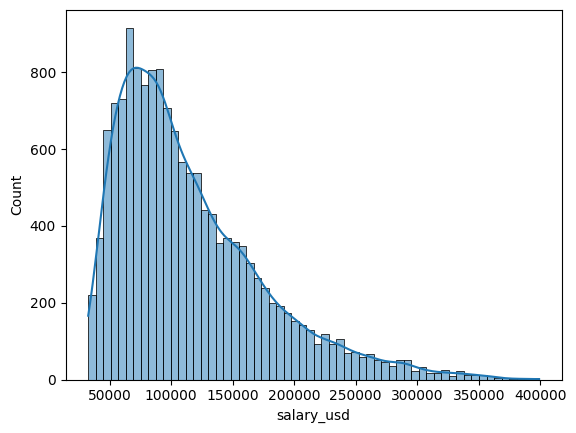

In [7]:
sns.histplot(data = df[target], log_scale=False, kde=True)

In [8]:
df[target].describe()

count     15000.000000
mean     115348.965133
std       60260.940438
min       32519.000000
25%       70179.750000
50%       99705.000000
75%      146408.500000
max      399095.000000
Name: salary_usd, dtype: float64

- Interesante mencionar que el 50% de los datos no supera los 100K dolares, y el 75% está por debajo de 150K dólares. 

##### Paso 5. Ingeniería de features

1. Codificación para las variables con valores únicos menores a 4

In [9]:
dic_el = {'EN':0, 'MI': 1, 'SE':2, 'EX':3}  # orden justificado según experiencia laboral
dic_cs = {'S': 0, 'M': 1, 'L':2} # orden según el tamaño de la compañia, de menos trabajadores a más.
dic_rr = {0 : 0, 50: 1, 100:2}  # orden según si es totalmente presencial o si es 100% en remoto. La mitad es hibrido
dic_er = {'Associate' : 0, 'Bachelor': 1, 'Master': 2, 'PhD': 3} # orden establecido según escala de formación
dic_sc = {'USD' : 0, 'EUR': 1, 'GBP': 2} # orden establecido según la fuerza relativa de la moneda, siendo el dolar más débil y la libra más fuerte

train_set['experiencia'] = train_set.experience_level.map(dic_el)
train_set['tamaño_compañia'] = train_set.company_size.map(dic_cs)
train_set['modalidad'] = train_set.remote_ratio.map(dic_rr)
train_set['formacion_min'] = train_set.education_required.map(dic_er)
train_set['tipo_moneda'] = train_set.salary_currency.map(dic_sc)

test_set['experiencia'] = test_set.experience_level.map(dic_el)
test_set['tamaño_compañia'] = test_set.company_size.map(dic_cs)
test_set['modalidad'] = test_set.remote_ratio.map(dic_rr)
test_set['formacion_min'] = test_set.education_required.map(dic_er)
test_set['tipo_moneda'] = test_set.salary_currency.map(dic_sc)

In [10]:
features = ['experiencia', 'tamaño_compañia', 'modalidad', 'formacion_min', 'tipo_moneda']

2. Transformación de la variable 'n_skills' según número de habilidades/competencias

In [11]:
train_set['n_skills'] = train_set['required_skills'].apply(lambda x: len(x.split(',')))
test_set['n_skills'] = test_set['required_skills'].apply(lambda x: len(x.split(',')))
train_set['n_skills'].value_counts()

n_skills
3    4049
4    3980
5    3971
Name: count, dtype: int64

In [12]:
features.append('n_skills')

3. Agrupación de la columna 'company_location' según región a escala continental

In [13]:
train_set.company_location.value_counts()

company_location
Germany           638
Austria           631
France            629
Canada            621
Denmark           617
Switzerland       615
Sweden            607
Japan             599
Israel            598
Singapore         597
United Kingdom    597
China             595
India             594
Australia         593
Ireland           591
Netherlands       591
South Korea       588
Norway            573
United States     570
Finland           556
Name: count, dtype: int64

In [14]:
def locality(x):
    if x in ["Germany", "Austria", "France", "Denmark", "Switzerland", "Sweden",
    "United Kingdom", "Ireland", "Netherlands", "Norway", "Finland"]:
        return 'Europa'
    elif x in ["Canada", "United States"]:
        return 'America_Norte'
    elif x in ["Japan", "Israel", "Singapore", "China", "India", "South Korea"]:
        return 'Asia'
    elif x in ['Australia']:
        return 'Oceania'
    

train_set['Region'] = train_set['company_location'].apply(locality)
test_set['Region'] = test_set['company_location'].apply(locality)

- Transformo la columna Region a binaria con OneHotEncoding

In [15]:
train_set = pd.get_dummies(train_set, columns=['Region'], dtype = int)
test_set = pd.get_dummies(test_set, columns=['Region'], dtype = int)

In [16]:
features.extend(col for col in train_set.columns if col.startswith('Region'))

- Transformo la columna 'company_location' a binaria con OneHotEncoding

In [17]:
train_set = pd.get_dummies(train_set, columns=['company_location'], dtype = int)
test_set = pd.get_dummies(test_set, columns=['company_location'], dtype = int)

In [18]:
features.extend(col for col in train_set.columns if col.startswith('company'))

4. Agregados estadísticos

- Transformación de los nombres de las compañías, 'company_title', en base a la media de los salarios por compañía

In [19]:
mean_salary = train_set.groupby('company_name')['salary_usd'].mean()
train_set['company_avg_salary'] = train_set['company_name'].map(mean_salary)
test_set['company_avg_salary'] = test_set['company_name'].map(mean_salary)

In [20]:
features.append('company_avg_salary')

- Transformación de los títulos de puestos de trabajo, 'job_title', según la mediana de los salarios por puesto de trabajo

In [21]:
mediana = train_set.groupby('job_title')['salary_usd'].median()
train_set['job_median_salary'] = train_set['job_title'].map(mediana)
test_set['job_median_salary'] = test_set['job_title'].map(mediana)

In [22]:
features.append('job_median_salary')

- Transformación de la industria, 'industry', en base a la mediana del salario según sector

In [23]:
median = train_set.groupby('industry')['salary_usd'].median()
train_set['industry_median_salary'] = train_set['industry'].map(median)
test_set['industry_median_salary'] = test_set['industry'].map(median)

In [24]:
features.append('industry_median_salary')

5. Creación columna 'plazo_oferta' que refleja la duración activa de la oferta de trabajo

In [25]:
train_set['posting_date'] = pd.to_datetime(train_set['posting_date'])                       # conversión de la columna a formato fecha de pandas
train_set['application_deadline'] = pd.to_datetime(train_set['application_deadline'])       # conversión de la columna a formato fecha de pandas

train_set['plazo_oferta'] = (train_set['application_deadline'] - train_set['posting_date']).dt.days

In [26]:
features.append('plazo_oferta')

In [27]:
test_set['posting_date'] = pd.to_datetime(test_set['posting_date'])
test_set['application_deadline'] = pd.to_datetime(test_set['application_deadline'])

test_set['plazo_oferta'] = (test_set['application_deadline'] - test_set['posting_date']).dt.days

6. Desglose de la columna 'employment_type' según la duración de la jornada, autónomo o contrato temporal.

In [28]:
train_set['jornada'] = 0
train_set.loc[train_set['employment_type'] == 'PT', 'jornada'] = 1  # media jornada
train_set.loc[train_set['employment_type'] == 'FT', 'jornada'] = 2  # jornada completa

train_set['Autonomo'] = (train_set['employment_type'] == 'FL').astype(int)      # Autonomo: Si o No
train_set['Contrato_temporal'] = (train_set['employment_type'] == 'CT').astype(int)     # Contrato_teporal: Si o No


test_set['jornada'] = 0
test_set.loc[test_set['employment_type'] == 'PT', 'jornada'] = 1  
test_set.loc[test_set['employment_type'] == 'FT', 'jornada'] = 2 

test_set['Autonomo'] = (test_set['employment_type'] == 'FL').astype(int)
test_set['Contrato_temporal'] = (test_set['employment_type'] == 'CT').astype(int)

In [29]:
features.append('jornada')
features.append('Autonomo')
features.append('Contrato_temporal')

##### Paso 6. MiniEDA y Selección de features de manera personal

In [ ]:
features.remove('plazo_oferta')     # features categoricas
features_num = ['years_experience', 'plazo_oferta', 'benefits_score', 'job_description_length']

1. Primero analicemos las features numéricas con respecto al target

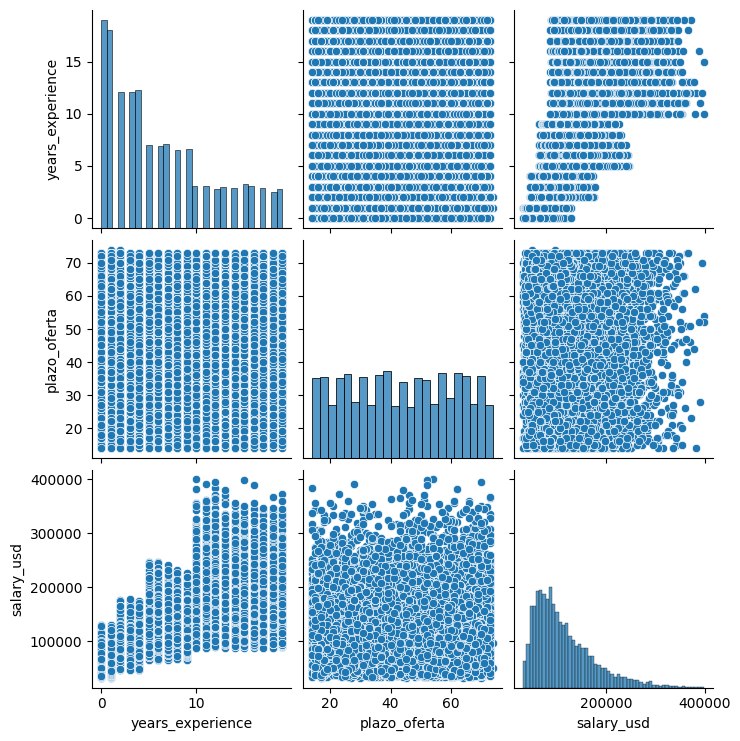

In [31]:
sns.pairplot(train_set[features_num + [target]])

In [32]:
corr = train_set[features_num + [target]].corr()
serie_corr = np.abs(corr[target]).sort_values(ascending = False)
serie_corr

salary_usd          1.000000
years_experience    0.735575
plazo_oferta        0.008371
Name: salary_usd, dtype: float64

- Nos quedamos con 'years_experience' debido a su alta correlación.

In [33]:
feat_sel = ['years_experience']

2. Ahora pasemos a analizar las variables categóricas con respecto al target mediante ANOVA_oneway

In [35]:
features.remove('company_size')
features.remove('company_name')

In [36]:

for col in features:
        valores_unicos = train_set[col].unique()
        col_salario = [train_set[train_set[col] == categoria][target] for categoria in valores_unicos]
        f_val, p_val = stats.f_oneway(*col_salario)

        print(f"La relación de {col} con {target} tiene valor F:", f_val, "Valor p:", p_val)

        if p_val <= 0.05:
                feat_sel.append(col)

La relación de experiencia con salary_usd tiene valor F: 6011.471489008899 Valor p: 0.0
La relación de tamaño_compañia con salary_usd tiene valor F: 252.28565232439556 Valor p: 4.733444413550363e-108
La relación de modalidad con salary_usd tiene valor F: 1.737322168281537 Valor p: 0.17603531865025565
La relación de formacion_min con salary_usd tiene valor F: 2.161926808042474 Valor p: 0.09028381378145253
La relación de tipo_moneda con salary_usd tiene valor F: 28.34935190932189 Valor p: 5.212369428707529e-13
La relación de n_skills con salary_usd tiene valor F: 0.4941255479863275 Valor p: 0.6101165970691849
La relación de Region_America_Norte con salary_usd tiene valor F: 73.7051545980576 Valor p: 1.0183491829564285e-17
La relación de Region_Asia con salary_usd tiene valor F: 764.9746616806702 Valor p: 2.763819534421757e-163
La relación de Region_Europa con salary_usd tiene valor F: 352.78485699965023 Valor p: 1.3540606045444948e-77
La relación de Region_Oceania con salary_usd tiene va

- Las features seleccionadas están basadas en correlación y relaciones estadísticamente significativas con respecto al target

In [37]:
feat_sel

['years_experience',
 'experiencia',
 'tamaño_compañia',
 'tipo_moneda',
 'Region_America_Norte',
 'Region_Asia',
 'Region_Europa',
 'Region_Oceania',
 'company_location_Australia',
 'company_location_Austria',
 'company_location_China',
 'company_location_Denmark',
 'company_location_Finland',
 'company_location_Germany',
 'company_location_India',
 'company_location_Ireland',
 'company_location_Israel',
 'company_location_Japan',
 'company_location_Netherlands',
 'company_location_Norway',
 'company_location_Singapore',
 'company_location_South Korea',
 'company_location_Sweden',
 'company_location_Switzerland',
 'company_location_United Kingdom',
 'company_location_United States']

3. Creo un diccionario con la primera lista seleccionada de manera personal

In [38]:
dic_listas = {'lista_seleccionada' : feat_sel}

##### Paso 7. Selección de features en base a otros criterios

1. Selección de features por ANOVA y KBest

In [ ]:
'''
f_classif realiza un test ANOVA
a técnica de análisis de varianza (ANOVA) también conocida como análisis factorial y desarrollada por Fisher en 1930,
constituye la herramienta básica para el estudio del efecto de uno o más factores (cada uno con dos o más niveles) sobre
la media de una variable continua. Es por lo tanto el test estadístico a emplear cuando se desea comparar las medias de
dos o más grupos.
'''

X_train_ANOVA = train_set[features]
y_train = train_set[target]
selector = SelectKBest(f_classif, k=20)             # Selección de 20 features
x_data_kbest = selector.fit_transform(X_train_ANOVA, y_train)
X_train_kbest = pd.DataFrame(x_data_kbest, columns = selector.get_feature_names_out())
lista_ANOVA = X_train_kbest.columns.to_list()
lista_ANOVA.append('years_experience')
dic_listas['lista_ANOVA'] = lista_ANOVA


In [41]:
dic_listas['lista_ANOVA']

['experiencia',
 'tamaño_compañia',
 'modalidad',
 'Region_America_Norte',
 'company_location_Austria',
 'company_location_Canada',
 'company_location_Denmark',
 'company_location_Germany',
 'company_location_Ireland',
 'company_location_Israel',
 'company_location_Netherlands',
 'company_location_Norway',
 'company_location_Singapore',
 'company_location_Sweden',
 'company_location_Switzerland',
 'company_location_United States',
 'company_avg_salary',
 'industry_median_salary',
 'jornada',
 'Autonomo',
 'years_experience']

2. Selección de features mediante eliminación recursiva (RFE)

In [42]:
feat_all = features + features_num

- Creo una primera lista con 20 features

In [ ]:

rf_reg = RandomForestRegressor(random_state= 42, max_depth=10)      # instanciamos un RandomForest como modelo 
rf_reg 

rfe = RFE(estimator = rf_reg,
          n_features_to_select= 20, # Iterará hasta quedarse con 20
          step = 1) # Elimina de una en una, pero es configurable

rfe.fit(train_set[feat_all], y_train)
#print(rfe.ranking_)
pd.DataFrame(rfe.ranking_, columns= ["ranking"], index = feat_all).sort_values("ranking")

,ranking
experiencia,1
tamaño_compañia,1
modalidad,1
tipo_moneda,1
Region_Asia,1
company_location_Denmark,1
company_location_Austria,1
Region_Europa,1
company_location_Finland,1
company_location_Sweden,1


- Paso a dataframe las columnas seleccionadas y extraigo los nombres de las columnas para guardarlos en el diccionario de listas

In [47]:
X_train_rfe = pd.DataFrame(rfe.transform(train_set[feat_all]), columns = rfe.get_feature_names_out())
lista_RFE = X_train_rfe.columns.to_list()
dic_listas['lista_RFE_20'] = lista_RFE

- Acoto una segunda lista a 15 features

In [45]:
rfe = RFE(estimator = rf_reg,
          n_features_to_select= 15, # Iterará hasta quedarse con 15
          step = 1) # Elimina de una en una, pero es configurable

rfe.fit(train_set[feat_all], y_train)

X_train_rfe = pd.DataFrame(rfe.transform(train_set[feat_all]), columns = rfe.get_feature_names_out())
lista_RFE_15 = X_train_rfe.columns.to_list()
dic_listas['lista_RFE_15'] = lista_RFE_15

3. Selección Secuencial de Features (SFS)

In [ ]:

sfs_forward = SequentialFeatureSelector(rf_reg,
                                        n_features_to_select = 20,
                                        cv = 4,
                                        scoring = "neg_mean_absolute_error")


sfs_forward.fit(train_set[feat_all], y_train)


SequentialFeatureSelector(cv=4,
                          estimator=RandomForestRegressor(max_depth=10,
                                                          random_state=42),
                          n_features_to_select=20,
                          scoring='neg_mean_absolute_error')

In [50]:
X_train_sfs = pd.DataFrame(sfs_forward.transform(train_set[feat_all]), columns = sfs_forward.get_feature_names_out())
lista_sfs = X_train_sfs.columns.to_list()
dic_listas['lista_SFS'] = lista_sfs

- Añado también una lista con todas las features

In [51]:
dic_listas['all_features'] = feat_all

In [52]:
dic_listas.keys()

dict_keys(['lista_seleccionada', 'lista_ANOVA', 'lista_RFE_15', 'lista_RFE_20', 'lista_SFS', 'all_features'])

##### Paso 8. Selección de la lista y el modelo de predicción con menor valor de MAE

In [53]:
model_names = ["DecisionTree","Random Forest","XGBoost","LightGBM","CatBoost"]

tree_reg = DecisionTreeRegressor(random_state= 42, max_depth=10)            #modelo baseline
rf_reg = RandomForestRegressor(random_state= 42, max_depth=10)
xgb_reg = XGBRegressor(random_state = 42, max_depth=10)
lgb_reg = LGBMRegressor(random_state= 42, verbose = -100, max_depth=10)
cat_reg = CatBoostRegressor(random_state= 42, verbose = False, max_depth=10)

model_set = [tree_reg, rf_reg, xgb_reg, lgb_reg, cat_reg]

- Realizamos una validación cruzada de cada una de las listas con cada uno de los modelos para obtener la métrica deseada más baja.

In [54]:
for tipo, features in dic_listas.items():
    print(f"Para el set {tipo}:")
    for nombre,modelo in zip(model_names, model_set):
        print(f"{nombre}: ", end = " ")
        print(-np.mean(cross_val_score(modelo, train_set[features], y_train, cv = 5, scoring = "neg_mean_absolute_error")))
    print('*********')

Para el set lista_seleccionada:
DecisionTree:  15715.564814086267
Random Forest:  15130.08649147992
XGBoost:  15294.37890625
LightGBM:  14459.813869328136
CatBoost:  14921.292348709898
*********
Para el set lista_ANOVA:
DecisionTree:  19375.69303120715
Random Forest:  18244.543774141363
XGBoost:  19160.95078125
LightGBM:  16853.704948669543
CatBoost:  17798.58672100548
*********
Para el set lista_RFE_15:
DecisionTree:  16541.074844628154
Random Forest:  15177.9254264321
XGBoost:  16323.2498046875
LightGBM:  14605.160921516941
CatBoost:  15240.343255821568
*********
Para el set lista_RFE_20:
DecisionTree:  16541.074844628154
Random Forest:  15177.9254264321
XGBoost:  16323.2498046875
LightGBM:  14605.160921516941
CatBoost:  15240.343255821568
*********
Para el set lista_SFS:
DecisionTree:  15350.837815055385
Random Forest:  14865.416513130778
XGBoost:  14373.289453125
LightGBM:  14362.315423785429
CatBoost:  14373.089124845737
*********
Para el set all_features:
DecisionTree:  16786.725

##### - La lista ganadora es la obtenida mediante Selección Secuencial de Features 
##### - El modelo ganador es LightGBM

##### Paso 9. Optimización del modelo

In [55]:
X_train = train_set[lista_sfs]
y_train = train_set[target]
X_test = test_set[lista_sfs]
y_test = test_set[target]

1. En primer lugar optimizamos con un GridSearch con sus hiperparámetros. Transformamos el target con logaritmo para mejorar la métrica. 

In [56]:
y_train_log = np.log(y_train)
lgb_reg = LGBMRegressor(verbose = -100, random_state=42)

param_grid= {'max_depth': [3, 6, 10, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          'bagging_fraction': [0.3,0.6,1],
          'feature_fraction': [0.5,1],
          'n_estimators': [100, 250, 500, 750],
          'max_bins': [125,250]
          }

lgb_grid = GridSearchCV(lgb_reg, 
                        cv = 5,
                        param_grid= param_grid, 
                        scoring = "neg_mean_absolute_error",
                        n_jobs=-1)


lgb_grid.fit(X_train, y_train_log)
print("LGB best_score:", np.abs(lgb_grid.best_score_))

LGB best_score: 0.11917957417765593


- Ahora probamos el modelo con sus mejores hiperparámetros frente a test. Transformamos la predicción con la exponencial, la opuesta del logaritmo. 

In [57]:
y_pred_log = lgb_grid.best_estimator_.predict(X_test)
y_pred = np.expm1(y_pred_log)
print("MAE:", mean_absolute_error(y_test,y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


MAE: 14503.923245973316
RMSE: 20044.105427423296


- Para saber la importancia de cada feature:

In [58]:
features = pd.DataFrame({'Feature': X_train.columns , 'importancia': lgb_grid.best_estimator_.feature_importances_}).sort_values(by = 'importancia', ascending = False)
features['Importancia_%'] = 100* features['importancia'] / features['importancia'].sum()
features

,Feature,importancia,Importancia_%
0,experiencia,661,23.152364
1,tamaño_compañia,597,20.910683
19,company_location_United States,180,6.304729
3,Region_Asia,175,6.129597
5,Region_Oceania,158,5.534151
4,Region_Europa,150,5.253940
15,company_location_Singapore,134,4.693520
17,company_location_Switzerland,99,3.467601
7,company_location_China,80,2.802102
14,company_location_Norway,80,2.802102


2. Vamos a probar con el hiperparametrizador Optuna

In [59]:
import optuna

def objective(trial):
    # Hiperparámetros a optimizar (elige 4 o 5)
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3,6, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    model = LGBMRegressor(**params)
    score = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
    return -np.mean(score)

# Crea el estudio de Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100) 

# Muestra los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:")
print(study.best_params)

# Entrena el modelo final
best_model = LGBMRegressor(**study.best_params)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
print(f"MAE en test: {mae:.2f}")

c:\Users\MARTA\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-07-02 17:48:17,755] A new study created in memory with name: no-name-5d74df1c-710b-4e45-97dd-b9b67bff7d2b
C:\Users\MARTA\AppData\Local\Temp\ipykernel_16228\412068167.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'max_depth': trial.suggest_int('max_depth', 3,6, 15),
c:\Users\MARTA\AppData\Local\Programs\Python\Pytho

Mejores hiperparámetros:
{'n_estimators': 386, 'learning_rate': 0.12330869030809194, 'num_leaves': 134, 'max_depth': 3, 'min_child_samples': 86}
MAE en test: 14497.66


##### Paso 10. Guardar el modelo

In [60]:
import joblib

joblib.dump(best_model, './src/models/modelo_optuna.pkl')

['./src/models/modelo_optuna.pkl']

##### Paso 11. Buscar alternativas para mejorar la métrica. Clusterización

- Vuelvo a instanciar los modelos para cerciorarme de que no he modificado ninguno

In [72]:
model_names = ["DecisionTree","Random Forest","XGBoost","LightGBM","CatBoost"]

tree_reg = DecisionTreeRegressor(random_state= 42, max_depth=10)            #modelo baseline
rf_reg = RandomForestRegressor(random_state= 42, max_depth=10)
xgb_reg = XGBRegressor(random_state = 42, max_depth=10)
lgb_reg = LGBMRegressor(random_state= 42, verbose = -100, max_depth=10)
cat_reg = CatBoostRegressor(random_state= 42, verbose = False, max_depth=10)

model_set = [tree_reg, rf_reg, xgb_reg, lgb_reg, cat_reg]

- Genero la segmentación en 3 clusters según los sueldos estén por debajo de 100k, entre 100k y 146k y por encima de 146k

In [67]:
mediana = train_set['salary_usd'].median()
q75 = train_set['salary_usd'].quantile(0.75)

# Crear la nueva columna de niveles de salario
train_set['segmentacion'] = train_set['salary_usd'].apply(lambda x: 0 if x < mediana else (1 if x < q75 else 2))
test_set['segmentacion'] = test_set['salary_usd'].apply(lambda x: 0 if x < mediana else (1 if x < q75 else 2))

- Me creo los datasets por separado para cada cluster

In [76]:
segmento_0 = train_set.loc[train_set.segmentacion == 0]
y_train_0 = train_set.loc[train_set.segmentacion == 0, target]
segmento_1 = train_set.loc[train_set.segmentacion == 1]
y_train_1 = train_set.loc[train_set.segmentacion == 1, target]
segmento_2 = train_set.loc[train_set.segmentacion == 2]
y_train_2 = train_set.loc[train_set.segmentacion == 2, target]
test_segmento_0 = test_set.loc[test_set.segmentacion == 0]
y_test_0 = test_set.loc[test_set.segmentacion == 0, target]
test_segmento_1 = test_set.loc[test_set.segmentacion == 1]
y_test_1 = test_set.loc[test_set.segmentacion == 1, target]
test_segmento_2 = test_set.loc[test_set.segmentacion == 2]
y_test_2 = test_set.loc[test_set.segmentacion == 2, target]

- Utilizo el diccionario de listas creado anteriormente y le hago la validación cruzada a cada cluster

1. Cluster 1

In [75]:
for tipo, features in dic_listas.items():
    print(f"Para el set {tipo}:")
    for nombre,modelo in zip(model_names, model_set):
        print(f"{nombre}: ", end = " ")
        print(-np.mean(cross_val_score(modelo, segmento_0[features], y_train_0, cv = 5, scoring = "neg_mean_absolute_error")))
    print('*********')

Para el set lista_seleccionada:
DecisionTree:  6980.482451313559
Random Forest:  6903.174547048085
XGBoost:  6931.89462890625
LightGBM:  6832.445895285122
CatBoost:  6901.036398366929
*********
Para el set lista_ANOVA:
DecisionTree:  8940.371401802953
Random Forest:  8468.798086789266
XGBoost:  9610.5453125
LightGBM:  8359.579595669817
CatBoost:  8795.321041056635
*********
Para el set lista_RFE_15:
DecisionTree:  7519.226159940597
Random Forest:  6996.775196149613
XGBoost:  7834.54365234375
LightGBM:  6918.432561454373
CatBoost:  7216.563688842786
*********
Para el set lista_RFE_20:
DecisionTree:  7519.226159940597
Random Forest:  6996.775196149613
XGBoost:  7834.54365234375
LightGBM:  6918.432561454373
CatBoost:  7216.563688842786
*********
Para el set lista_SFS:
DecisionTree:  6944.909508654414
Random Forest:  6846.095274507691
XGBoost:  6733.61083984375
LightGBM:  6768.714580209048
CatBoost:  6739.086317262379
*********
Para el set all_features:
DecisionTree:  7493.636583965432
Ran

- Para Cluster 1 se obtiene la lista_SFS y como modelo el XGBoost

In [80]:
X_train_0 = segmento_0[lista_sfs]
X_test_0 = test_segmento_0[lista_sfs]

In [81]:
xgb_r = XGBRegressor(verbose=-100, random_state =42)
y_train_0_log = np.log(y_train_0)

param_grid = {'max_depth': [3, 6, 10, 15],
          'learning_rate': [0.2, 0.6, 0.9],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': [100, 250, 500, 750],
          }

xgb_grid = GridSearchCV(xgb_r, 
                               cv = 5,
                               param_grid= param_grid, 
                               scoring = "neg_mean_absolute_error",
                               n_jobs = -1)


xgb_grid.fit(X_train_0, y_train_0_log)
print("XGB best_score:", np.sqrt(-xgb_grid.best_score_))


XGB best_score: 0.3164688979514613


c:\Users\MARTA\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:27:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [83]:
y_pred_log = xgb_grid.best_estimator_.predict(X_test_0)
y_pred = np.expm1(y_pred_log)
print("MAE:", mean_absolute_error(y_test_0,y_pred))

MAE: 6711.02490234375


In [ ]:
joblib.dump(xgb_grid.best_estimator_, './src/models/modelo_cluster_1.pkl')

['./src/models/modelo_segmento_0.pkl']

2. Cluster 2

In [85]:
for tipo, features in dic_listas.items():
    print(f"Para el set {tipo}:")
    for nombre,modelo in zip(model_names, model_set):
        print(f"{nombre}: ", end = " ")
        print(-np.mean(cross_val_score(modelo, segmento_1[features], y_train_1, cv = 5, scoring = "neg_mean_absolute_error")))
    print('*********')

Para el set lista_seleccionada:
DecisionTree:  8826.651416639954
Random Forest:  8737.462643682476
XGBoost:  9151.4404296875
LightGBM:  8629.26778816015
CatBoost:  8873.769665716387
*********
Para el set lista_ANOVA:
DecisionTree:  10008.856102962714
Random Forest:  9387.969273793764
XGBoost:  10746.3451171875
LightGBM:  9475.506981527145
CatBoost:  10136.088414960772
*********
Para el set lista_RFE_15:
DecisionTree:  9787.257076890079
Random Forest:  8854.629000833627
XGBoost:  9842.059375
LightGBM:  8958.722693051459
CatBoost:  9346.68788968502
*********
Para el set lista_RFE_20:
DecisionTree:  9787.257076890079
Random Forest:  8854.629000833627
XGBoost:  9842.059375
LightGBM:  8958.722693051459
CatBoost:  9346.68788968502
*********
Para el set lista_SFS:
DecisionTree:  8529.155702453254
Random Forest:  8497.971363300068
XGBoost:  8411.498046875
LightGBM:  8465.119142748761
CatBoost:  8415.833606350305
*********
Para el set all_features:
DecisionTree:  9596.404817072897
Random Forest

- Se obtiene mejor métrica con la lista_SFS y el modelo XGBoost

In [86]:
X_train_1 = segmento_1[lista_sfs]
X_test_1 = test_segmento_1[lista_sfs]

In [87]:
xgb_r = XGBRegressor(verbose=-100, random_state =42)
y_train_1_log = np.log(y_train_1)

param_grid = {'max_depth': [3, 6, 10, 15],
          'learning_rate': [0.2, 0.6, 0.9],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': [100, 250, 500, 750],
          }

xgb_grid = GridSearchCV(xgb_r, 
                               cv = 5,
                               param_grid= param_grid, 
                               scoring = "neg_mean_absolute_error",
                               n_jobs = -1)


xgb_grid.fit(X_train_1, y_train_1_log)
print("XGB best_score:", np.sqrt(-xgb_grid.best_score_))


c:\Users\MARTA\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:35:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGB best_score: 0.26375617768980486


In [88]:
y_pred_log = xgb_grid.best_estimator_.predict(X_test_1)
y_pred = np.expm1(y_pred_log)
print("MAE:", mean_absolute_error(y_test_1,y_pred))

MAE: 8515.97265625


In [ ]:
joblib.dump(xgb_grid.best_estimator_, './src/models/modelo_cluster_2.pkl')

['./src/models/modelo_segmento_1.pkl']

3. Cluster 3

In [90]:
for tipo, features in dic_listas.items():
    print(f"Para el set {tipo}:")
    for nombre,modelo in zip(model_names, model_set):
        print(f"{nombre}: ", end = " ")
        print(-np.mean(cross_val_score(modelo, segmento_2[features], y_train_2, cv = 5, scoring = "neg_mean_absolute_error")))
    print('*********')

Para el set lista_seleccionada:
DecisionTree:  25274.792427208922
Random Forest:  24579.14981678494
XGBoost:  25779.462890625
LightGBM:  24151.75781703015
CatBoost:  24929.5236708124
*********
Para el set lista_ANOVA:
DecisionTree:  28761.14413103804
Random Forest:  25967.25310106628
XGBoost:  28368.662109375
LightGBM:  25942.48689599587
CatBoost:  27263.157377445255
*********
Para el set lista_RFE_15:
DecisionTree:  26583.529184189298
Random Forest:  24408.256998186494
XGBoost:  27012.546484375
LightGBM:  24586.205743364604
CatBoost:  25647.23457803959
*********
Para el set lista_RFE_20:
DecisionTree:  26583.529184189298
Random Forest:  24408.256998186494
XGBoost:  27012.546484375
LightGBM:  24586.205743364604
CatBoost:  25647.23457803959
*********
Para el set lista_SFS:
DecisionTree:  24240.807103447565
Random Forest:  23829.46233477933
XGBoost:  23541.1828125
LightGBM:  23551.984917174355
CatBoost:  23539.229270380536
*********
Para el set all_features:
DecisionTree:  27843.33624474

- Lista ganadora la obtenida mediante seleccion secuencial de features y el modelo XGBoost

In [91]:
X_train_2 = segmento_2[lista_sfs]
X_test_2 = test_segmento_2[lista_sfs]

In [93]:
xgb_r = XGBRegressor(verbose=-100, random_state =42)
y_train_2_log = np.log(y_train_2)

param_grid = {'max_depth': [3, 6, 10, 15],
          'learning_rate': [0.2, 0.6, 0.9],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': [100, 250, 500, 750],
          }

xgb_grid = GridSearchCV(xgb_r, 
                               cv = 5,
                               param_grid= param_grid, 
                               scoring = "neg_mean_absolute_error",
                               n_jobs = -1)


xgb_grid.fit(X_train_2, y_train_2_log)
print("XGB best_score:", np.sqrt(-xgb_grid.best_score_))

c:\Users\MARTA\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:22:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGB best_score: 0.3342425386182795


In [94]:
y_pred_log = xgb_grid.best_estimator_.predict(X_test_2)
y_pred = np.expm1(y_pred_log)
print("MAE:", mean_absolute_error(y_test_2,y_pred))

MAE: 23484.595703125


In [95]:
joblib.dump(xgb_grid.best_estimator_, './src/models/modelo_cluster_3.pkl')

['./src/models/modelo_cluster_3.pkl']

El MAE obtenido por el cluster 3 es superior al valor MAE obtenido en la regresión conjunta. El problema está en el desequilibrio que genera este MAE al romper el promedio, y por tanto la opción de clusterizar el modelo y mejorar las métricas se anula. Además, nos arriesgamos a un salto de 9k (con respecto a 14k) de MAE sólo porque se haya clasificado en el rango alto. Por tanto, nos quedamos con la regresión inicial que es más robusta, uniforme y tiene menor riesgo de clasificación errónea.

Al descartar la opción de clusterización, no se procede al modelado de un algoritmo supervisado de clasificación